# Advertiser_SalesModel_LSTM:
---

### Long short-term memory recurrent neural networks...
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
import os
import us
import math
import mpld3
import keras
import keras.preprocessing.sequence
import cycler
import theano
import lasagne
import tabulate
import warnings
import sqlalchemy
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.fftpack
import statsmodels.api
import theano.tensor as tt
import patsy, patsy.contrasts
import seaborn.apionly as sns
import tflearn.models.generator
import statsmodels.tsa.stattools
import matplotlib as mpl, matplotlib.pyplot as plt
import cachetools
import sklearn, sklearn.preprocessing
plt.style.use(['classic'])
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_categories', 300)
pd.set_option('display.width', 208)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.memory_usage', True)
pd.set_option('display.precision', 7)
%matplotlib inline

---
## Configuration:
---

In [3]:
np.random.seed(314)
categorical_encoding = None
master_hdf = 'data/Advertiser_master_dataframe.hdf'

---
## Data Sources:
---

In [4]:
with pd.HDFStore(master_hdf) as hdf:
    print(hdf.keys())

['/badcrash_buzz', '/city_sales', '/crash_buzz', '/digi_acts', '/digi_acts_bystate', '/digi_acts_bystate_flat', '/digi_acts_flat', '/digi_acts_raw', '/digi_imps', '/digi_imps_bystate', '/digi_imps_cats', '/digi_imps_cats_bystate', '/digi_imps_cats_bystate_flat', '/digi_imps_cats_flat', '/digi_imps_flat', '/djta', '/fuel', '/fuel_bystate', '/ga', '/ga_bystate', '/gtrends', '/gtrends_bystate', '/merged', '/merged_acts', '/merged_noacts', '/merged_state', '/merged_state_noacts', '/offline', '/sales', '/search_acts', '/search_acts_flat', '/search_imps', '/search_imps_flat', '/social_buzz', '/social_buzz_bystate', '/state_sales', '/yougov']


In [5]:
sales = pd.read_hdf(master_hdf, 'sales');
sales.head()

,datebin,sales,tickets,miles
0,2014-08-01,3491401.26,65377,23912295
1,2014-08-02,2478987.94,47588,18552616
2,2014-08-03,2313267.87,41391,16021091
3,2014-08-04,2459971.96,45280,18790057
4,2014-08-05,2244840.98,41618,18530113


In [6]:
df = pd.read_hdf(master_hdf, 'merged_noacts');
df = df.drop(['tickets','miles','revenue'], axis = 1)
print(df.shape)
df.head()

(719, 37)


,sales,sessions_count,newusers,transactions,ooh_cost,radio_cost,gtrend,fuel_price,djta,social_buzz,crash_buzz,badcrash_buzz,search_cost,search_branded_cost,search_clicks,search_branded_clicks,search_impressions,search_branded_impressions,digicat_brand_non_riders,digicat_brand_non_riders_prospecting,digicat_brand_non_riders_retargeting,digicat_brand_riders,digicat_brand_riders_retargeting,digicat_email,digicat_influencers,digicat_mobile,digicat_native,digicat_pricing_non_riders_prospecting,digicat_pricing_non_riders_retargeting,digicat_pricing_riders_retargeting,digicat_promo_non_riders_prospecting,digicat_promo_non_riders_retargeting,digicat_promo_riders_retargeting,digicat_social_ads,digicat_social_video,digicat_video,digicat_video_banner
datebin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1691411.48,137868.0,71264.0,7003.0,1992.1371705,0.0,66.2829332,2.2599692,75.3394993,466.0,25.0,17.0,1256.89,593.86,6683.0,8896.0,99206.0,31685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,2415880.02,163713.0,83484.0,9087.0,1992.1371705,0.0,69.8703824,2.2462073,75.1689990,510.0,16.0,10.0,1310.38,593.15,7217.0,9361.0,111389.0,33156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,2141196.72,147545.0,76044.0,7458.0,1992.1371705,0.0,75.5516662,2.2324454,74.5401660,532.0,23.0,16.0,1278.28,586.60,6942.0,8990.0,91613.0,32708.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,2240770.62,146054.0,76084.0,6967.0,1992.1371705,0.0,60.1411739,2.2186835,73.9113329,719.0,51.0,41.0,1282.02,611.98,7507.0,9547.0,97867.0,34605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,2075052.08,147646.0,76056.0,8041.0,1992.1371705,0.0,54.4567602,2.2049216,73.2824998,983.0,263.0,32.0,966.41,382.62,5987.0,5528.0,75132.0,21753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
## LSTM  Bulk:
---

In [116]:
# normalize the dataset
bulk_scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))
bulk_dataset = bulk_scaler.fit_transform(df)

In [117]:
bulk_dataset.shape

(719, 35)

In [118]:
bulk_dataset[0]

array([ 0.19162263,  0.51511562,  0.68283587,  0.3171891 ,  0.29443764,
        0.        ,  0.57149866,  0.51358685,  0.97478658,  0.01577789,
        0.44495462,  0.28307085,  0.38784748,  0.35755627,  0.53898729,
        0.32840323,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [119]:
# split into train and test sets
train_size = int(len(bulk_dataset) * 0.8)
test_size = len(bulk_dataset) - train_size
train, test = bulk_dataset[0:train_size,:], bulk_dataset[train_size:len(bulk_dataset),:]
print(train.shape, test.shape)

(575, 35) (144, 35)


In [120]:
def create_dataset_bulk(dataset, look_back = 1):
	dataX, dataY = [], []
	for i in range(len(dataset) - look_back - 1):
		a = bulk_dataset[i:(i + look_back), 1:]
		dataX.append(a)
		dataY.append(bulk_dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [121]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset_bulk(train, look_back)
testX, testY = create_dataset_bulk(test, look_back)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(573, 1, 34) (573,) (142, 1, 34) (142,)


In [113]:
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [122]:
# create and fit the LSTM network
bulk_lstm_model = keras.models.Sequential()
bulk_lstm_model.add(keras.layers.recurrent.LSTM(1, input_dim = 34))
bulk_lstm_model.add(keras.layers.Dense(1))
bulk_lstm_model.compile(loss='mean_squared_error', optimizer='adam')
bulk_lstm_model.fit(trainX, trainY, nb_epoch = 10, batch_size = 1, verbose = 2)

Epoch 1/10
12s - loss: 0.0251
Epoch 2/10
10s - loss: 0.0149
Epoch 3/10
11s - loss: 0.0143
Epoch 4/10
11s - loss: 0.0139
Epoch 5/10
11s - loss: 0.0136
Epoch 6/10
11s - loss: 0.0134
Epoch 7/10
11s - loss: 0.0132
Epoch 8/10
11s - loss: 0.0130
Epoch 9/10
10s - loss: 0.0128
Epoch 10/10
11s - loss: 0.0127


In [149]:
trainScore = bulk_lstm_model.evaluate(trainX, trainY, verbose=0)
trainScore = np.sqrt(trainScore)
trainScore = bulk_scaler.inverse_transform(np.array([[trainScore]*(1+trainX.shape[-1])]))[0][0]
print('Train Score: %.2f RMSE' % (trainScore))
testScore = bulk_lstm_model.evaluate(testX, testY, verbose=0)
testScore = np.sqrt(testScore)
testScore = bulk_scaler.inverse_transform(np.array([[testScore]*(1+trainX.shape[-1])]))[0][0]
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1356706.82 RMSE
Test Score: 1306230.63 RMSE


In [150]:
trainPredict = bulk_lstm_model.predict(trainX)
testPredict = bulk_lstm_model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(bulk_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(bulk_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(bulk_dataset)-1, :] = testPredict

In [153]:
sales.head()

,datebin,sales,tickets,miles
0,2014-08-01,3491401.26,65377,23912295
1,2014-08-02,2478987.94,47588,18552616
2,2014-08-03,2313267.87,41391,16021091
3,2014-08-04,2459971.96,45280,18790057
4,2014-08-05,2244840.98,41618,18530113


In [158]:
 bulk_scaler.inverse_transform(trainPredictPlot)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

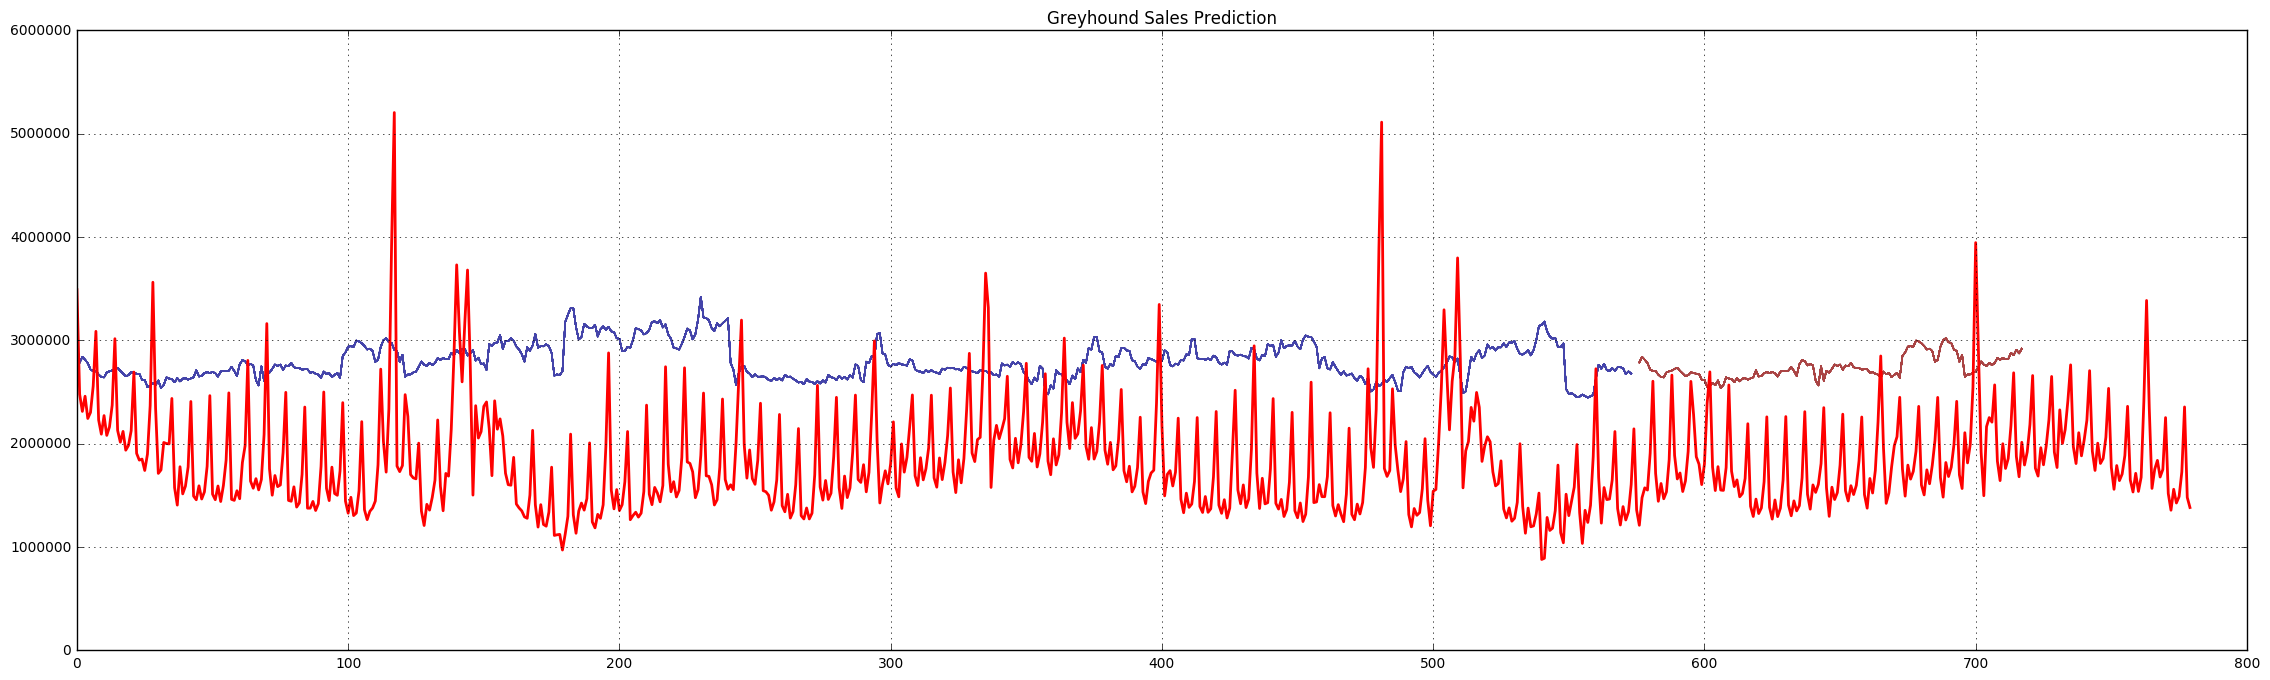

In [160]:
scale_factor = sales.sales.max() - sales.sales.min()
scale_shift = sales.sales.mean()
fig, ax = plt.subplots(1, 1, figsize = (28,8))
#plt.plot(dataset)
ax.plot(trainPredictPlot*scale_factor + scale_shift, lw = 1, c = '#4444aa')
ax.plot(testPredictPlot*scale_factor + scale_shift, lw = 1, c = '#aa4444')
ax.plot(sales.sales, lw = 2, c = 'red')
ax.set_title('Advertiser Sales Prediction')
ax.grid()
#sales.query('datebin >= "2015-01-01"').sales.plot(figsize = (28,8), grid = True);

---
## LSTM Sales Prediction:
---

In [ ]:
def create_dataset2(dataset, look_back = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [ ]:
def lstm_sales(df, train_pct = 0.8, look_back = 1):
    # normalization
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))
    sales_scaled = scaler.fit_transform(df.sales)
    sales_scale_factor = df.sales.max()
    # split into train and test sets
    train_size = int(len(sales_scaled) * train_pct)
    test_size = len(sales_scaled) - train_size
    train, test = sales_scaled[0:train_size], sales_scaled[train_size:len(sales_scaled)]
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset2(train, look_back)
    testX, testY = create_dataset2(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    lstm_model = keras.models.Sequential()
    lstm_model.add(keras.layers.LSTM(1, input_dim = 1))
    lstm_model.add(keras.layers.Dense(1))
    lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    lstm_model.fit(trainX, trainY, nb_epoch = 10, batch_size = 1, verbose = 0)
    trainScore = lstm_model.evaluate(trainX, trainY, verbose=0)
    trainScore = np.sqrt(trainScore)
    trainScore = scaler.inverse_transform(np.array([[trainScore]]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = lstm_model.evaluate(testX, testY, verbose=0)
    testScore = np.sqrt(testScore)
    testScore = scaler.inverse_transform(np.array([[testScore]]))
    print('Test Score: %.2f RMSE' % (testScore))
    trainPredict = lstm_model.predict(trainX).flatten()
    testPredict = lstm_model.predict(testX).flatten()
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(sales_scaled)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(sales_scaled)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(sales_scaled)-1] = testPredict
    fig, ax = plt.subplots(1, 1, figsize = (28,8))
    ax.plot(sales_scale_factor*sales_scaled, lw = 2, c = '#4444aa', label = 'Actual Sales')
    ax.plot(sales_scale_factor*trainPredictPlot, lw = 2, c = '#44aa44', label = 'Model Training')
    ax.plot(sales_scale_factor*testPredictPlot, lw = 2, c = '#aa4444', label = 'Model Prediction')
    ax.set_title('Advertiser Sales Prediction', fontsize = 18)
    ax.set_ylabel('$')
    ax.legend()
    ax.grid();

---
## Debugging:
---

In [9]:
def create_dataset_debug(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [64]:
train_pct = 0.8
# normalization
scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))
sales_scaled = scaler.fit_transform(sales.sales)
# split into train and test sets
train_size = int(len(sales_scaled) * train_pct)
test_size = len(sales_scaled) - train_size
train, test = sales_scaled[0:train_size], sales_scaled[train_size:len(sales_scaled)]

In [65]:
look_back = 1
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset_debug(train, look_back)
testX, testY = create_dataset_debug(test, look_back)

In [66]:
# reshape input to be [samples, time steps, features]
print((trainX.shape[0], 1, trainX.shape[1]))
print((testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

(622, 1, 1)
(154, 1, 1)


In [67]:
# create and fit the LSTM network
lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.LSTM(1, input_dim = 1))
lstm_model.add(keras.layers.Dense(1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [68]:
lstm_model.fit(trainX, trainY, nb_epoch = 10, batch_size = 1, verbose = 0)

In [77]:
trainScore = lstm_model.evaluate(trainX, trainY, verbose=0)
trainScore = np.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = lstm_model.evaluate(testX, testY, verbose=0)
testScore = np.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))
trainPredict = lstm_model.predict(trainX).flatten()
testPredict = lstm_model.predict(testX).flatten()

Train Score: 1319117.70 RMSE
Test Score: 1253536.90 RMSE


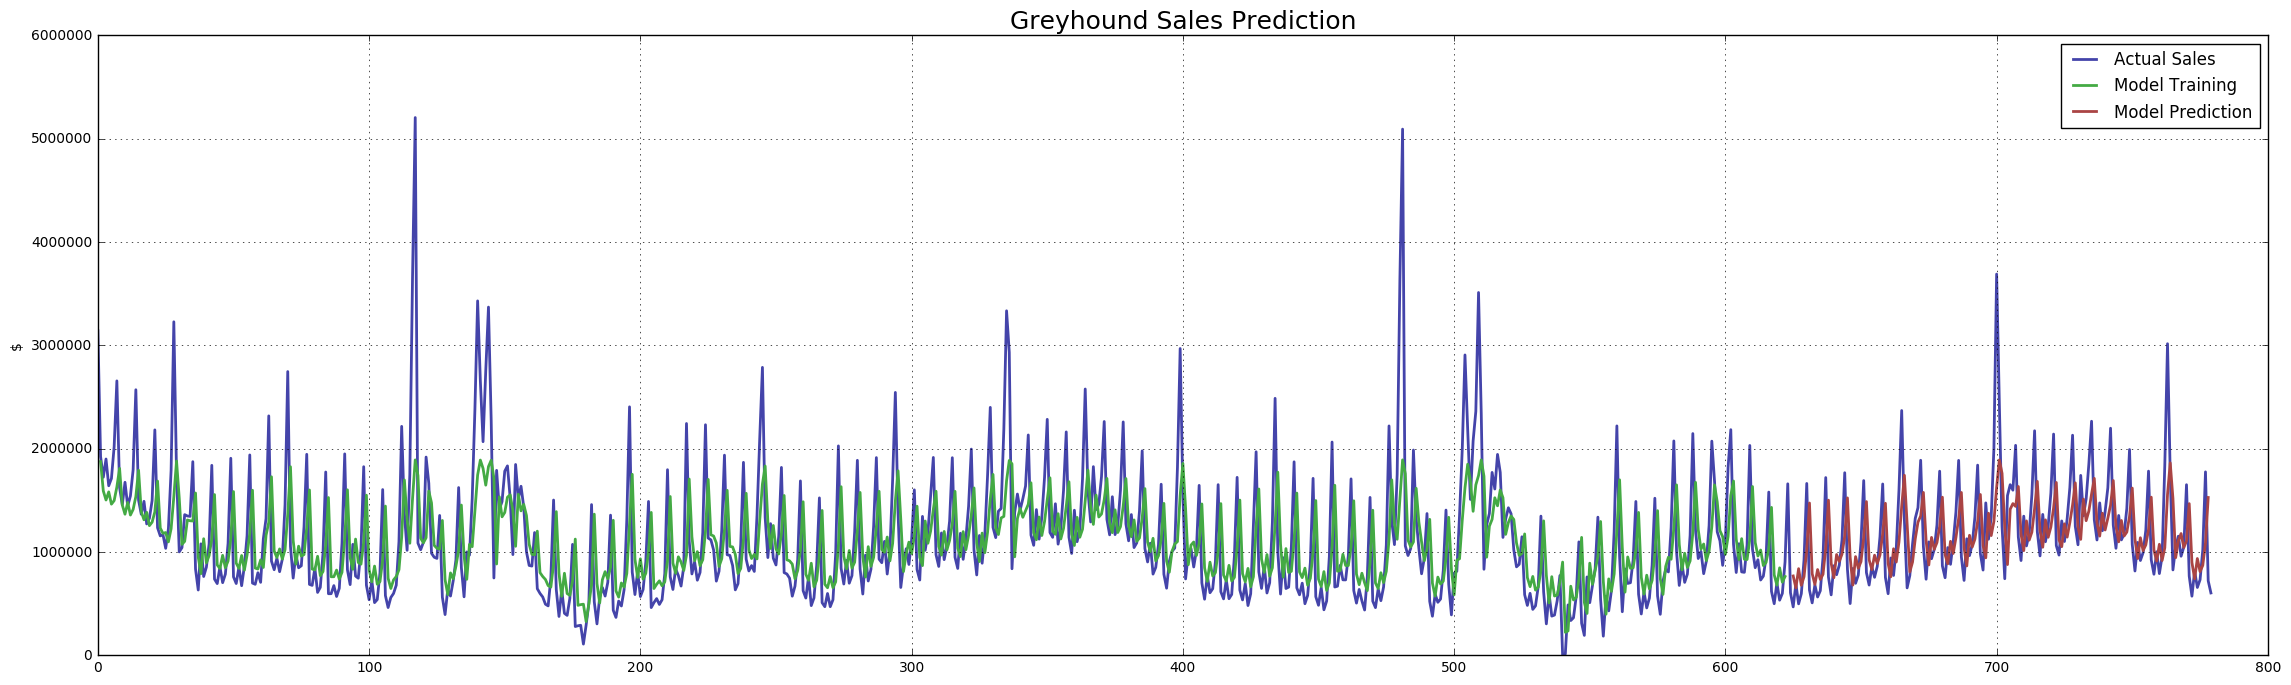

In [78]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(sales_scaled)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(sales_scaled)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(sales_scaled)-1] = testPredict
fig, ax = plt.subplots(1, 1, figsize = (28,8))
ax.plot(sales_scale_factor*sales_scaled, lw = 2, c = '#4444aa', label = 'Actual Sales')
ax.plot(sales_scale_factor*trainPredictPlot, lw = 2, c = '#44aa44', label = 'Model Training')
ax.plot(sales_scale_factor*testPredictPlot, lw = 2, c = '#aa4444', label = 'Model Prediction')
ax.set_title('Advertiser Sales Prediction', fontsize = 18)
ax.set_ylabel('$')
ax.legend()
ax.grid();

---
## Debugging 2:
---

In [244]:
train_pct = 1
# normalization
scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))
sales_scaled = scaler.fit_transform(sales.sales.values)
# split into train and test sets
train_size = len(sales_scaled)
train = sales_scaled

In [245]:
look_back = 7
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset_debug(train, look_back)

In [246]:
# reshape input to be [samples, time steps, features]
print((trainX.shape[0], 1, trainX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

(772, 1, 7)


In [248]:
trainX[0]

array([[ 0.60369547,  0.3696062 ,  0.33128856,  0.36520934,  0.31546695,
         0.3289922 ,  0.38806728]])

In [249]:
trainY[0]

0.51043139640538748

In [247]:
# create and fit the LSTM network
hidden_neurons = 30
lstm_model2 = keras.models.Sequential()
lstm_model2.add(keras.layers.LSTM(hidden_neurons, input_dim = look_back, return_sequences = False))
lstm_model2.add(keras.layers.Dropout(0.01))
lstm_model2.add(keras.layers.Dense(1))
lstm_model2.add(keras.layers.Activation("linear"))
lstm_model2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [236]:
lstm_model2.fit(trainX, trainY, nb_epoch = 10, batch_size = 1, verbose = 1)

Epoch 1/10
778/778 [==============================] - 15s - loss: 0.0115    
Epoch 2/10
778/778 [==============================] - 17s - loss: 0.0104    
Epoch 3/10
778/778 [==============================] - 15s - loss: 0.0103    
Epoch 4/10
778/778 [==============================] - 16s - loss: 0.0104    
Epoch 5/10
778/778 [==============================] - 16s - loss: 0.0104    
Epoch 6/10
778/778 [==============================] - 16s - loss: 0.0103    
Epoch 7/10
778/778 [==============================] - 16s - loss: 0.0103    
Epoch 8/10
778/778 [==============================] - 16s - loss: 0.0104    
Epoch 9/10
778/778 [==============================] - 17s - loss: 0.0102    
Epoch 10/10
778/778 [==============================] - 16s - loss: 0.0103    


In [237]:
trainScore = lstm_model2.evaluate(trainX, trainY, verbose=0)
trainScore = np.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 1314510.53 RMSE


In [242]:
trainPredict = lstm_model2.predict(trainX).flatten()

In [238]:
def wrapnum(x):
    return np.array([[[x]]])

In [239]:
s0 = sales_scaled[-1]
sp = s0
sales_prediction = []
for i in range(30):
    sp = lstm_model2.predict(wrapnum(sp))[0][0]
    sales_prediction.append(sp)
sales_prediction = np.array(sales_prediction)

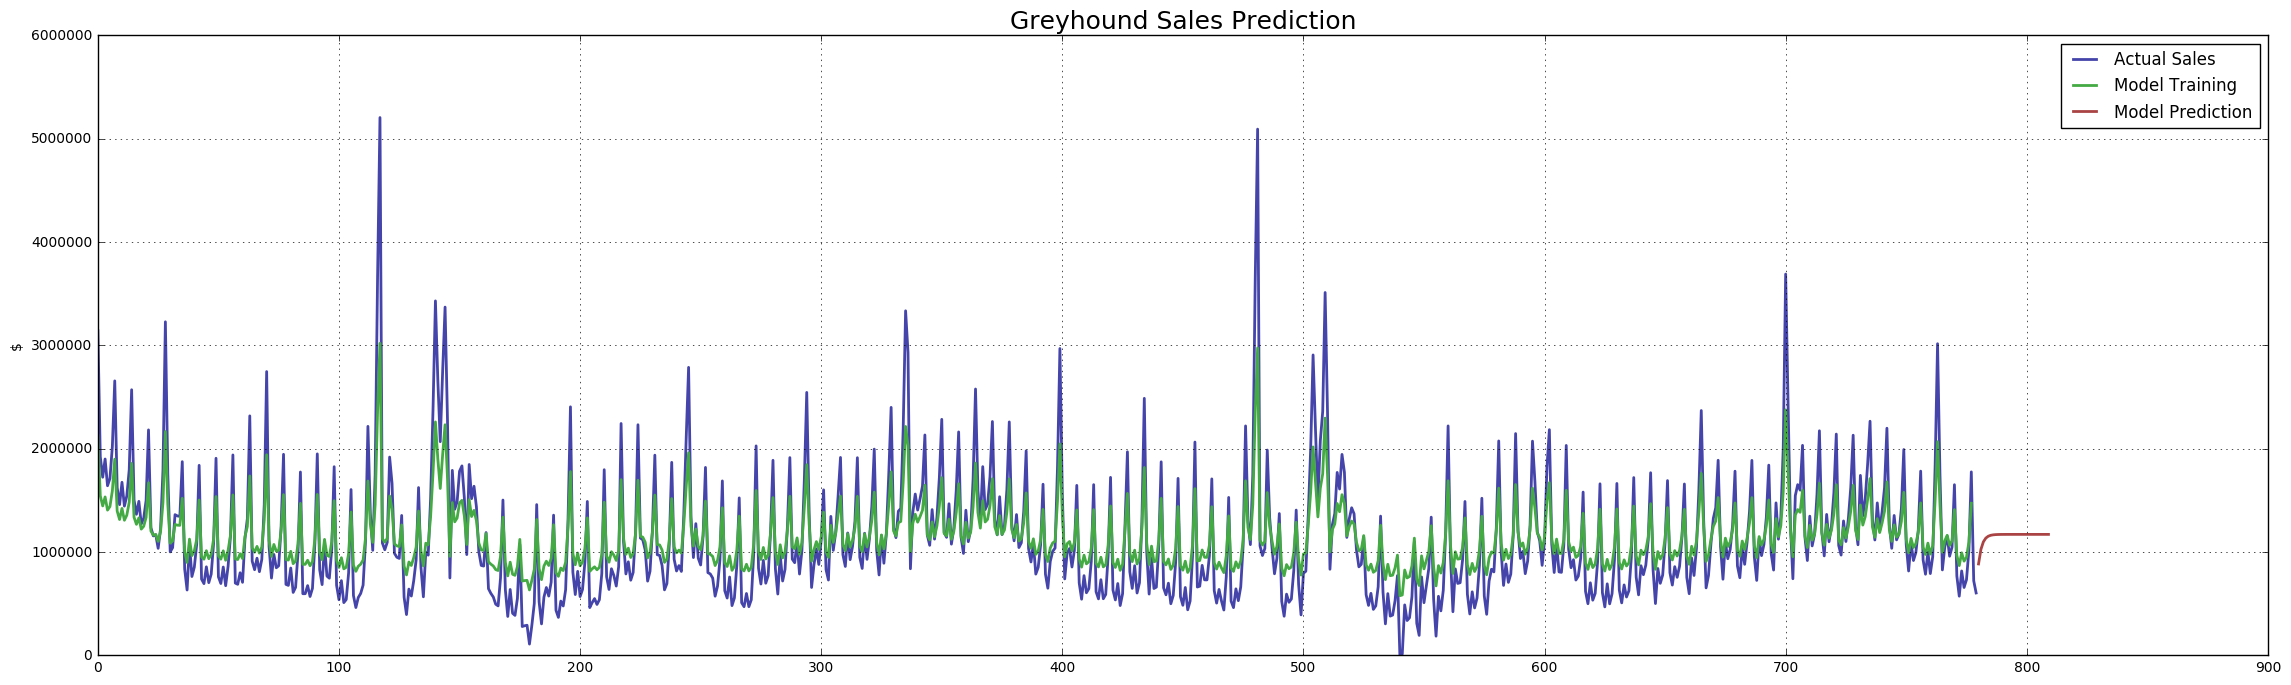

In [243]:
# shift train predictions for plotting
trainPredictPlot = trainPredict
fig, ax = plt.subplots(1, 1, figsize = (28,8))
ax.plot(sales_scale_factor*sales_scaled, lw = 2, c = '#4444aa', label = 'Actual Sales')
ax.plot(sales_scale_factor*trainPredictPlot, lw = 2, c = '#44aa44', label = 'Model Training')
ax.plot(np.arange(len(sales_scaled),len(sales_scaled)+30), sales_scale_factor*sales_prediction, lw = 2, c = '#aa4444', label = 'Model Prediction')
ax.set_title('Advertiser Sales Prediction', fontsize = 18)
ax.set_ylabel('$')
ax.legend()
ax.grid();

In [ ]:
testPredict = lstm_model2.predict(testX).flatten()

In [ ]:
sales_scale_factor*sales_prediction

---
## Multi-step prediction 1:
---

In [34]:
train_pct = 0.6
# normalization
scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))
sales_scaled = scaler.fit_transform(sales.sales.values)
# split into train and test sets
train_size = int(len(sales_scaled) * train_pct)
test_size = len(sales_scaled) - train_size
train, test = sales_scaled[0:train_size], sales_scaled[train_size:len(sales_scaled)]

In [13]:
def create_dataset_multistep(dataset, pre_steps = 90, post_steps = 30):
    dataX, dataY = [], []
    for idx in range(len(dataset) - pre_steps - post_steps):
        xdat = dataset[idx:idx + pre_steps]
        ydat = dataset[idx + pre_steps:idx + pre_steps + post_steps]
        dataX.append(xdat)
        dataY.append(ydat)
    return np.array(dataX), np.array(dataY)

In [14]:
trainX, trainY = create_dataset_multistep(train, 180, 90)
testX, testY = create_dataset_multistep(test, 180, 90)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(198, 180) (198, 90)
(42, 180) (42, 90)


In [15]:
# reshape input to be [samples, time steps, features]
print((trainX.shape[0], 1, trainX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

print((testX.shape[0], 1, testX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

(198, 1, 180)
(42, 1, 180)


In [16]:
# create and fit the LSTM network
hidden_neurons = 90
lstm_multistep = keras.models.Sequential()
lstm_multistep.add(keras.layers.LSTM(hidden_neurons, input_dim = 180, return_sequences = False))
lstm_multistep.add(keras.layers.Dropout(0.01))
lstm_multistep.add(keras.layers.Dense(90))
lstm_multistep.add(keras.layers.Activation("linear"))
lstm_multistep.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [17]:
lstm_multistep.fit(trainX, trainY, nb_epoch = 10, batch_size = 1, verbose = 1)

Epoch 1/10
198/198 [==============================] - 4s - loss: 0.0130     
Epoch 2/10
198/198 [==============================] - 3s - loss: 0.0066     
Epoch 3/10
198/198 [==============================] - 3s - loss: 0.0043     
Epoch 4/10
198/198 [==============================] - 4s - loss: 0.0034     
Epoch 5/10
198/198 [==============================] - 4s - loss: 0.0030     
Epoch 6/10
198/198 [==============================] - 4s - loss: 0.0027     
Epoch 7/10
198/198 [==============================] - 4s - loss: 0.0025     
Epoch 8/10
198/198 [==============================] - 4s - loss: 0.0023     
Epoch 9/10
198/198 [==============================] - 3s - loss: 0.0022     
Epoch 10/10
198/198 [==============================] - 4s - loss: 0.0021     


In [18]:
trainScore = lstm_multistep.evaluate(trainX, trainY, verbose=0)
trainScore = np.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 1065068.86 RMSE


In [19]:
testPredict = lstm_multistep.predict(testX)

In [20]:
testPredict.shape

(42, 90)

In [50]:
sales_scaled.shape


(780,)

In [51]:
sales.shape

(780, 4)

In [52]:
sales.head(2)

,datebin,sales,tickets,miles
0,2014-08-01,3491401.26,65377,23912295
1,2014-08-02,2478987.94,47588,18552616


DatetimeIndex(['2016-09-18', '2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28', '2016-09-29', '2016-09-30',
               '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07'],
              dtype='datetime64[ns]', freq='D')

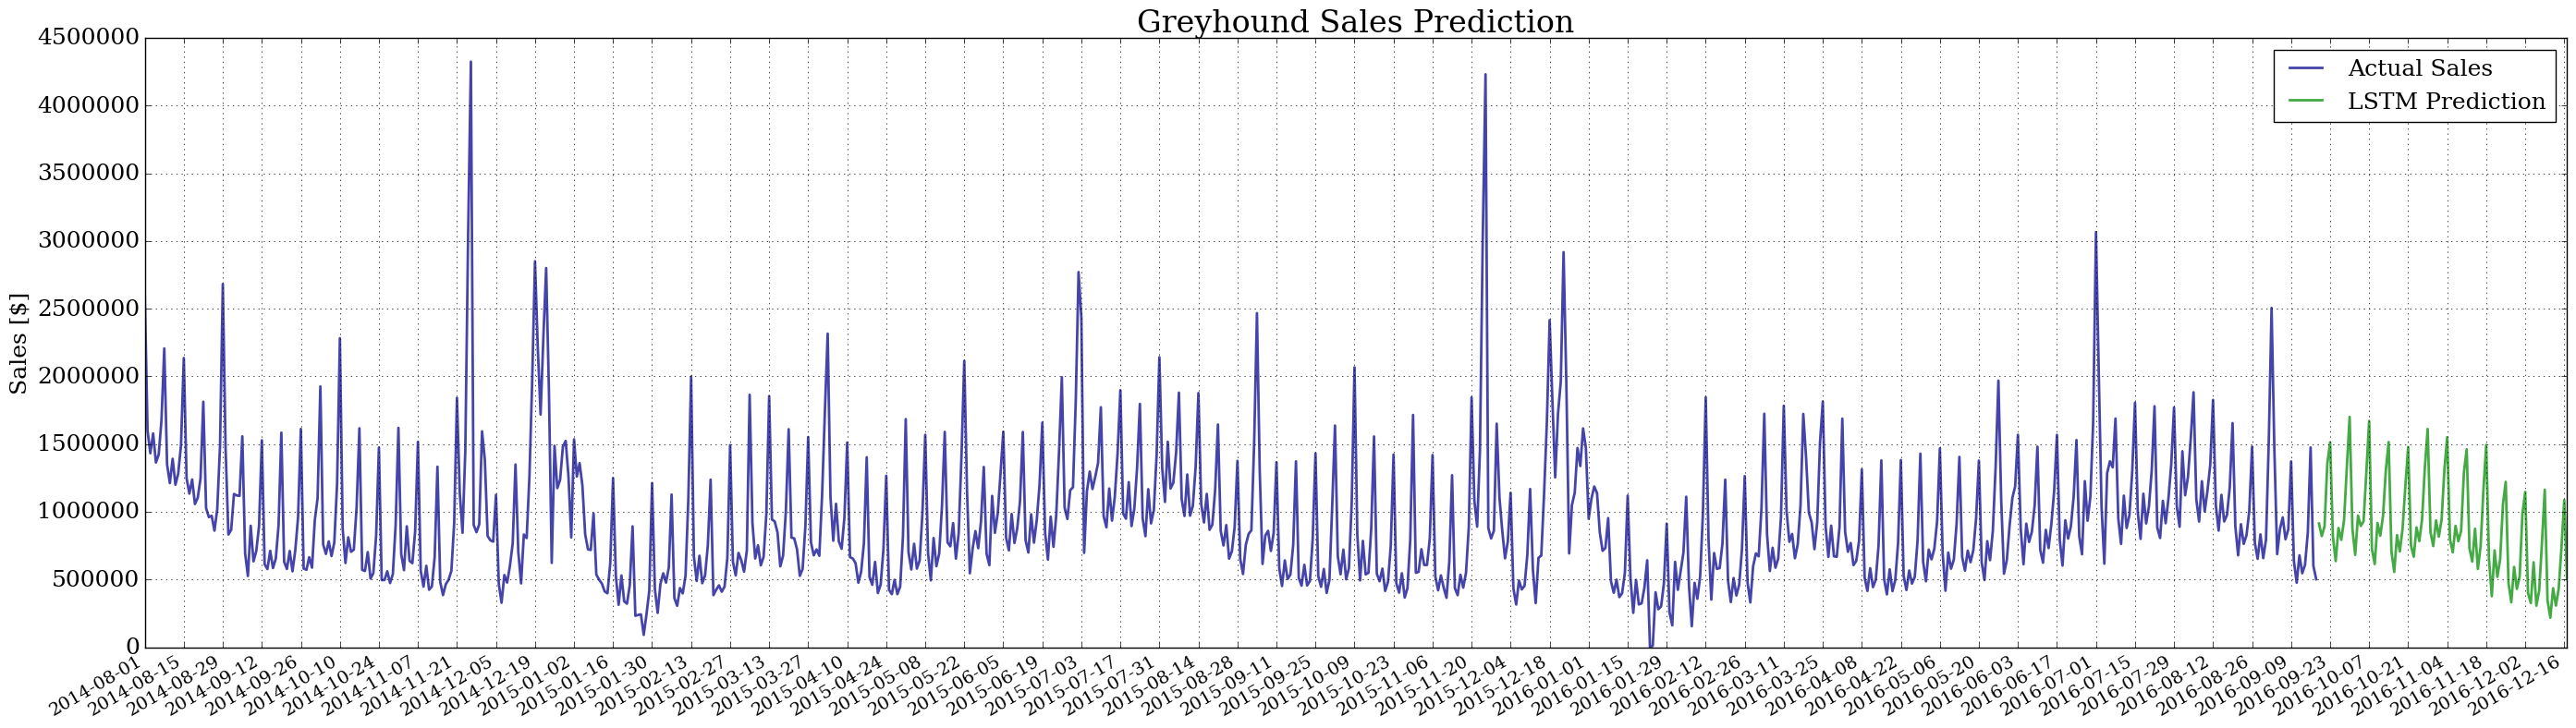

In [98]:
# shift train predictions for plotting
plt.rcParams['font.family'] = 'serif'
testPredictPlot = testPredict[-1]
sales_scale_factor = sales.sales.max() - sales.sales.min()
sales_scale_shift = sales_scaled[-1]*sales_scale_factor - testPredictPlot[-1]*sales_scale_factor
fig, ax = plt.subplots(1, 1, figsize = (28,8))
ax.plot(sales.datebin, sales_scale_factor*sales_scaled, lw = 2, c = '#4444aa', label = 'Actual Sales')
ax.plot(pd.date_range(sales.datebin.values[-1], periods = len(testPredictPlot)+1)[1:],
        sales_scale_factor*testPredictPlot + sales_scale_shift, lw = 2, c = '#44aa44', label = 'LSTM Prediction')
ax.set_title('Advertiser Sales Prediction', fontsize = 24)
ax.set_ylabel('Sales [$]')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_yticklabels()):
    item.set_fontsize(18)
for item in ax.get_xticklabels():
    item.set_fontsize(14)
ax.legend(fontsize = 18)
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval = 14))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))
ax.grid()
plt.tight_layout()
plt.savefig('charts/lstm_prediction.png')

In [24]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

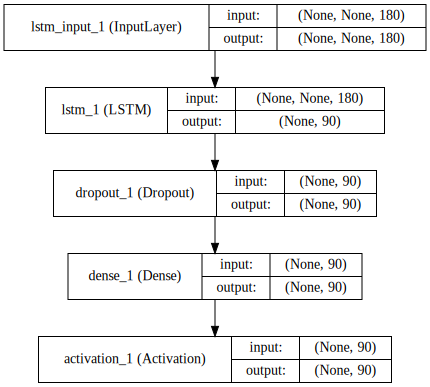

In [49]:
SVG(model_to_dot(lstm_multistep, show_shapes = True).create(prog='dot', format='svg'))
#plt.savefig('charts/lstm_model.eps')

#### Export data for chart...

In [87]:
exportdf_base = sales[['datebin', 'sales']].copy()
print(exportdf_base.shape)
exportdf_base.tail()

(780, 2)


,datebin,sales
775,2016-09-14,1489436.77
776,2016-09-15,1728011.63
777,2016-09-16,2356464.42
778,2016-09-17,1480893.94
779,2016-09-18,1382981.68


In [111]:
sales_scale_factor = sales.sales.max() - sales.sales.min()
sales_scale_shift = sales.sales.min() - sales_scale_factor*testPredictPlot.min()#sales_scaled[-1]*sales_scale_factor - testPredictPlot[-1]*sales_scale_factor

In [112]:
exportdf_prediction = pd.DataFrame(sales_scale_factor*testPredictPlot + sales_scale_shift,
                                   index = pd.date_range(sales.datebin.values[-1], periods = len(testPredictPlot)+1)[1:], columns = ['sales']).reset_index().rename(columns = {'index':'datebin'})
print(exportdf_prediction.shape)
exportdf_prediction.head()

(90, 2)


,datebin,sales
0,2016-09-19,1576730.75
1,2016-09-20,1483321.75
2,2016-09-21,1555532.75
3,2016-09-22,2020916.75
4,2016-09-23,2176358.00


In [113]:
exportdf = pd.concat([exportdf_base, exportdf_prediction]).reset_index(drop = True)
exportdf.head()

,datebin,sales
0,2014-08-01,3491401.26
1,2014-08-02,2478987.94
2,2014-08-03,2313267.87
3,2014-08-04,2459971.96
4,2014-08-05,2244840.98


In [114]:
exportdf.tail()

,datebin,sales
865,2016-12-13,969955.6875
866,2016-12-14,1093329.2500
867,2016-12-15,1400592.1250
868,2016-12-16,1749422.7500
869,2016-12-17,1164951.7500


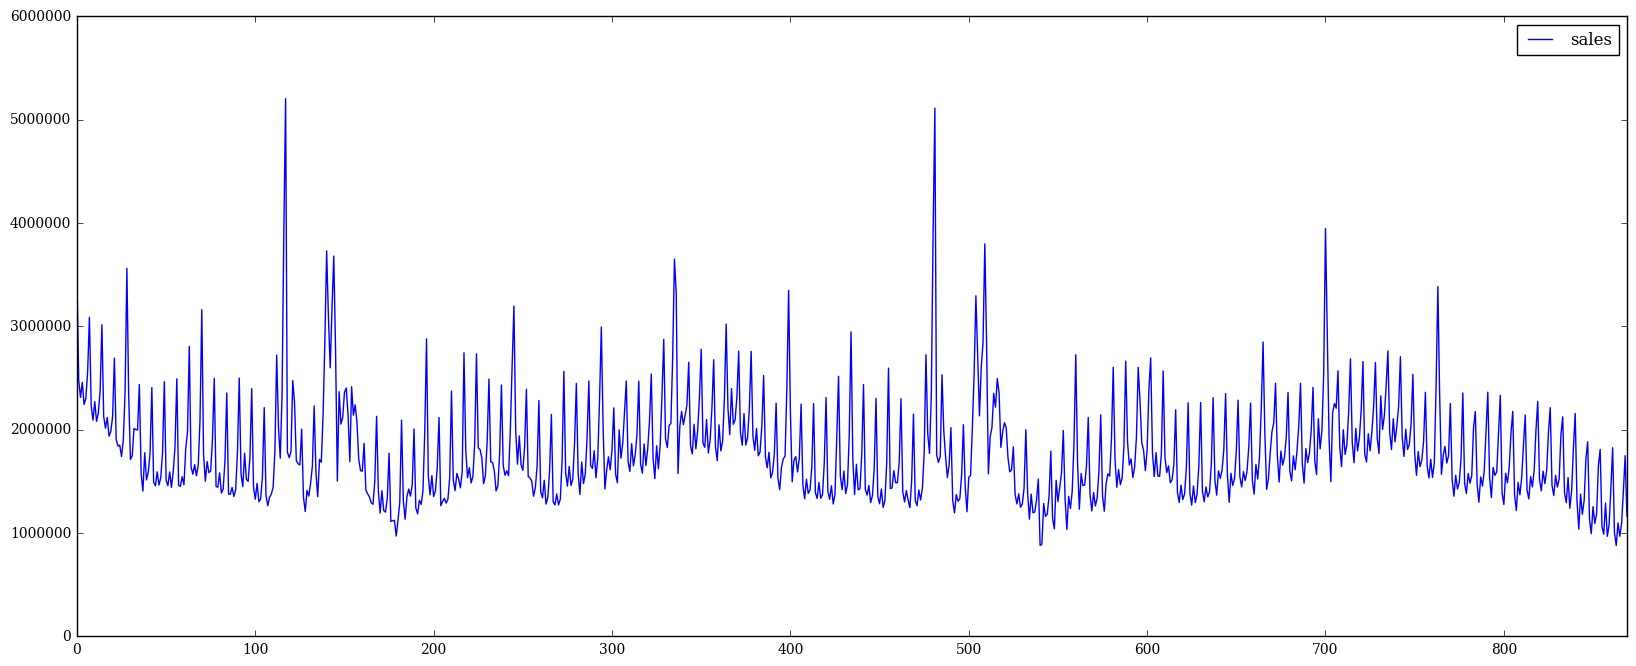

In [115]:
exportdf.plot(figsize = (20,8))

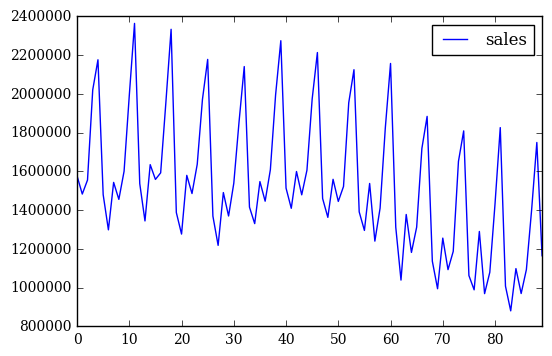

In [116]:
exportdf_prediction.plot()

In [117]:
exportdf.to_csv('data/lstm_prediction.csv', index = False)

---
## Multi-step prediction 2:
---

---
## LSTM  Sales Prediction Testing:
---

In [ ]:
lstm_sales(sales, train_pct = 0.3)

In [ ]:
lstm_sales(sales, train_pct = 0.5)

In [ ]:
lstm_sales(sales, train_pct = 0.8)